# Project purpose

The first goal of this research project is to get familiar with Mobile Robotics Library [MROB](https://github.com/MobileRoboticsSkoltech/mrob), specifically with geometry package which deal with rigid body transformations (RBT) and contains the SO(3) and SE(3) groups implementations.

Besides that, the problem of uncertainty propagation in localization tasks was selected as a research topic. As reference, the paper **Associating Uncertainty With Three-Dimensional Poses for Use in Estimation Problems" by Timothy D. Barfoot, Member, IEEE, and Paul T. Furgale, Member, IEEE** was selected. It contains examples of numerical experiments which can be used as reference to check implementations of implemented algorithms.


# TODO

## orientation visualization

# Tasks

* Implement block Cholesky decomposition for singular covariance matrix using pivoting of rows and columns;
* Implement Monte Carlo algorithm for direct uncertainty distribution sampling;
* Implement multivariate gaussian pose noise visualization, that is similar to one from reference paper;
* Implement pose compounding procedure of 2nd and 4th order from the reference paper;
* Compare all uncertainty propagation methods against the Monte Carlo algorithm;

# Plan
 
1. Compile MROB python bindings from C++ source code https://github.com/MobileRoboticsSkoltech/mrob;
2. Use MROB python bindings to implement methods for uncertainty visualization and propagation according to reference paper;
3. Compare implemented algorithms with direct sampling (Monte Carlo algorithm);
4. (????) Add C++ code for implemented methods into MROB source code repository;

# Expected and achieved results

## Cholesky decomposition for singular covariance matrix

Cholesky decomposition is used to calculate points on an covariance ellipsoid, which correspond to a particular sigma quantile of probability distribution:

$$
\Sigma = L\cdot L^T, \text{ where $\Sigma$ is covariance matrix and $L$ is lower-diagonal matrix}.
$$

To be able to work with different noise models and "turn off" noise along desired axis, but still be able to use decomposition, the preprocessing step required to select covariance sub-matrix which does not contain zero columns and rows and, thus, non-singular and positive defined. The following implementation proposed:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size': 22}

matplotlib.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
import scipy.stats
import seaborn as sns

from tqdm import tqdm

import mrob

In [2]:
# Here the Cholesky decomposition for singular covariance matrix is implmented
def cholesky(sigma):
    # obtaining map matrix betweein original and truncated matrix
    condition =~ (np.all(sigma == 0, axis=1) & (np.all(sigma == 0, axis=0)))
    m = [int(x) for x in condition]
    counter = 0
    res = []
    for el in m:
        if el > 0:
            res.append(counter)
            counter +=1
        else:
            res.append(None)
    M = []    
    for i in range(6):
        tmp = []
        for j in range(6):
            tmp.append([res[i],res[j]])
        
        M.append(tmp)
    M = np.array(M)
    
    # obtaining matrix that is obtained by removing zero columns and rows
    block = (sigma[condition,:])[:,condition]

    # applying regular cholesky decomposition
    L = np.linalg.cholesky(block)
    
    # mapping block decomposition into original matrix
    LL = np.zeros_like(sigma)
    
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if all(M[i,j] != None):
                k = M[i,j][0]
                l = M[i,j][1]
                LL[i,j] = L[k,l]
    # returning resulting factor
    return LL

Text(32.0, 0.5, "['z', 'y', 'x', 'yaw', 'pitch', 'roll']")

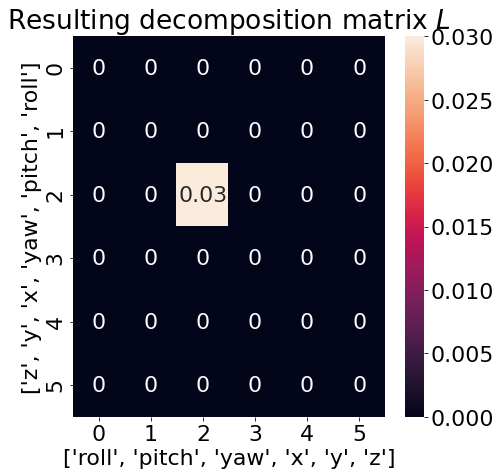

In [3]:
# Testing the implemented method
# The noise is defined only for one coordinate in covariance matrix sigma,
# other coordinates do not have any noise at all
sigma = np.diag([0,0,0.03**2,0,0,0]) 
L = cholesky(sigma)

plt.figure(figsize=(7,7))
plt.title("Resulting decomposition matrix $L$")
sns.heatmap(L,annot=True)
plt.xlabel(["roll","pitch","yaw","x","y","z"])
plt.ylabel(["z","y","x","yaw","pitch","roll"])

To check that obtained factor $L$ generates original matrix $\Sigma$:

In [4]:
print("Decomposition error: ", np.linalg.norm(sigma - L@L.transpose()))

Decomposition error:  0.0


In [5]:
# Testing on some random singular covariance matrices
N = 1000 # number of test to do
error = 0 # cumulative error
for _ in tqdm(range(N)):
    # Generating random diagonal elements of covariance matrix.
    # Adding +5 to be sure that it will be positive defined.
    tmp = np.random.randn(6) + 5
    
    # Noise for random coordinate is turned off
    tmp[np.random.randint(0,6)] = 0
    
    sigma = np.diag(tmp) # Matrix sigma is singular
    L = cholesky(sigma)
    error += np.linalg.norm(sigma - L@L.transpose())

print("Mean error: {}".format(error/N))

100%|██████████| 1000/1000 [00:00<00:00, 3853.07it/s]

Mean error: 1.3540230463176073e-15


Mean error is approximately equal to zero with machine precision for float type, which is about 1e-16.

## Monte Carlo direct sampling

To obtain distribution of disturbed poses after noise injection, the Monte Carlo algorithm can be used for direct sampling:

In [6]:
import sklearn.datasets

# generating noise samples according to given covariance matrix

# Noise has zero mean values
mean = np.zeros(6)

# Noise covariance matrix
sigma = np.diag([1e-10,1e-10,0.1,0.001,0.01,1e-10])

# Noise generator
norm_var = scipy.stats.multivariate_normal(mean,sigma)

# Samling noise samples and putting into the table
N = 100_000
xi = norm_var.rvs(N)

df = pd.DataFrame(xi)

In [7]:
df.head()

,0,1,2,3,4,5
0,-0.000002,-0.000020,-0.042791,-0.010364,-0.048604,-0.000002
1,-0.000006,-0.000006,0.208461,0.004000,0.058430,-0.000012
2,-0.000016,-0.000007,0.140631,0.012860,0.012354,-0.000010
3,-0.000003,-0.000028,-0.018786,-0.025874,-0.028583,0.000008
4,-0.000006,-0.000006,-0.080748,-0.034665,0.031623,0.000012


In [8]:
df.var()

0    9.950514e-11
1    9.942691e-11
2    1.005863e-01
3    9.867314e-04
4    1.007353e-02
5    9.973842e-11
dtype: float64

The noise is injected into SE(3) group using left hand side exponential map update, which was already implemented in current version of MROB library:

In [9]:
propagated = []
for i in range(len(xi)):
    tmp = mrob.geometry.SE3([0,0,0,1,0,0])
    tmp.update_lhs(xi[i])
    propagated.append(tmp)

The set of disturbed poses obtained and stored in list variable **propagated**. To visualize the distribution the $(x,y)$ coordinates of poses plotted on a scatter plot:

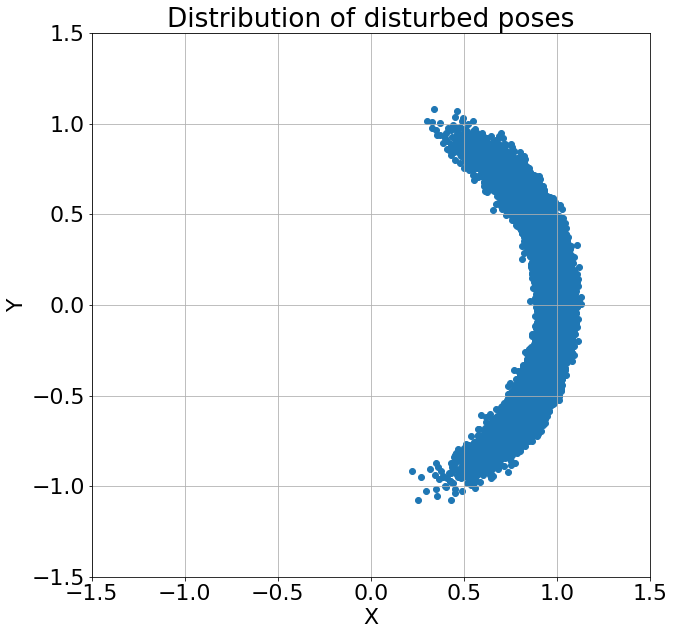

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

poses = np.array([x.t() for x in propagated])
poses = poses.reshape((-1,3))

plt.title('Distribution of disturbed poses')
plt.scatter(poses[:,0],poses[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

The dominating yaw angle noise causes so-called "banana-shaped" distribution.

## Covariance visualization

Similar to the lecture [$\ref{}$], instead of direct distribution sampling, the ellipsoid main circumferences can be projected on to the ground plane.

Using the Cholesky decomposition:

$$
\Sigma = L\cdot L^T
$$

we have matrix $L$ that is used to obtain points on covariance ellipsoid $\Sigma$:

$$
r_{\Sigma} = L\cdot r_I,
\tag{1}
\label{unit}
$$

where $r_I$ are big circles on a sphere, which go through every pair of coordinate axis. If $1-\sigma$ quantile visualized, then $r_I$ are sampled from unitary sphere. If $K-\sigma$ quantiles required, then $r_I$ is sampled from the sphere of radius $K$. Basically, the expression ($\ref{unit}$) transforms standard distribution $N(0,I)$ into given normal distribution $N(0,\Sigma)$ which is a subject for visualization.

Covariance matrix $\Sigma$ is the size of 6x6, but in this project we will consider body transformations that correspond only to motion on a flat surface, i.e. the noise for roll, pitch and z coordinates will be turned off and instead of 6D ellipsoid the 3D ellipsoid for **(yaw,x,y)** coordinates will be visualized.

The following naive implementation proposed. It sequentially samples points from big circles which go through pairs of axis : **(yaw, x), (yaw, y), (x, y)**. Besides that, ellipsoid axis visualized for **(yaw, x, y)**.

In [11]:
def sigma_visualize(T, sigma, N=100, K=[1,1]):
    N = 100
    
    plt.plot(T.t()[0], T.t()[1],'x')
    A = cholesky(sigma)
    for k in set(K):
        # plotting yaw & x plane
        labels = ['+yaw','-yaw','+x','-x']
        points = []
        points.append([0,0,k,0,0,0])
        points.append([0,0,-k,0,0,0])
        points.append([0,0,0,k,0,0])
        points.append([0,0,0,-k,0,0])


        for i in range(N+1):
            points.append([0,0,k*np.cos(2*np.pi/N*i), k*np.sin(2*np.pi/N*i),0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma yaw & x".format(k))
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color='green')
        
        # plotting x & y plane
        labels = ['+x','-x','+y','-y']
        points = []
        points.append([0,0,0,k,0,0])
        points.append([0,0,0,-k,0,0])
        points.append([0,0,0,0,k,0])
        points.append([0,0,0,0,-k,0])


        for i in range(N+1):
            points.append([0,0,0,k*np.cos(2*np.pi/N*i), k*np.sin(2*np.pi/N*i),0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma x & y".format(k))
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color='green')
    

    
        # plotting yaw & y plane
        labels = ['+yaw','-yaw','+y','-y']
        points = []
        points.append([0,0,k,0,0,0])
        points.append([0,0,-k,0,0,0])
        points.append([0,0,0,0,k,0])
        points.append([0,0,0,0,k,0])


        for i in range(N+1):
            points.append([0,0,k*np.cos(2*np.pi/N*i),0, k*np.sin(2*np.pi/N*i),0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma yaw & y".format(k))
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color='green')
        # plotting yaw axis of ellipsoid
        points = []

        for i in range(N+1):
            points.append([0,0,k - i*(2*k)/N, 0,0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1])
        
        # plotting x axis
        points = []
        for i in range(N+1):
            points.append([0,0,0,k - i*(2*k)/N,0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1])
        
        # plotting y axis
        points = []

        for i in range(N+1):
            points.append([0,0,0,0,k - i*(2*k)/N, 0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1])

    plt.xlabel("X")
    plt.ylabel("Y")

Trying to visualize some test examples and compare results against the Monte Carlo results:

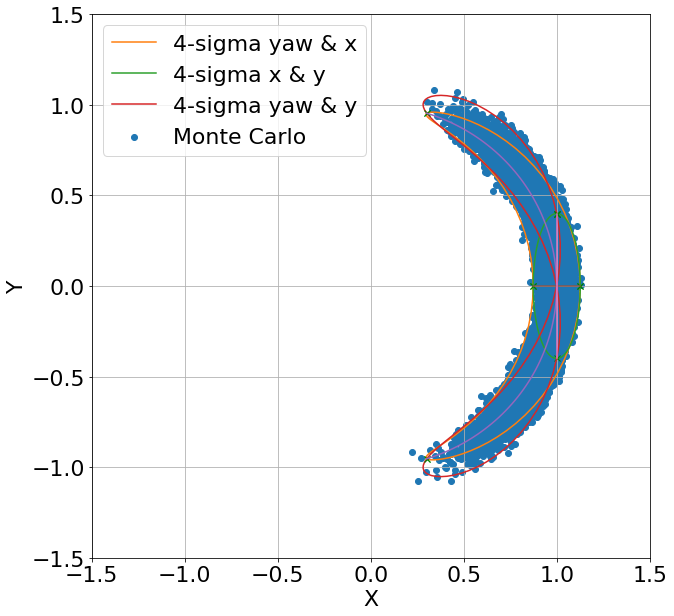

In [12]:
plt.figure(figsize=(10,10))
sigma = np.diag([0,0,0.1,0.001,0.01,0])

sigma_visualize(mrob.geometry.SE3([0,0,0,1,0,0]), sigma=sigma,N = 100, K=[4] )
plt.scatter(poses[:,0],poses[:,1], label='Monte Carlo')

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.legend()
plt.show()

Let's try another pose instead of simple shift along $x$ axis.

In [13]:
# some yaw rotation added

propagated = []
for i in range(len(xi)):
    tmp = mrob.geometry.SE3([0,0,0.9,1,0,0])
    tmp.update_lhs(xi[i])
    propagated.append(tmp)
    

poses = np.array([x.t() for x in propagated])
poses = poses.reshape((-1,3))

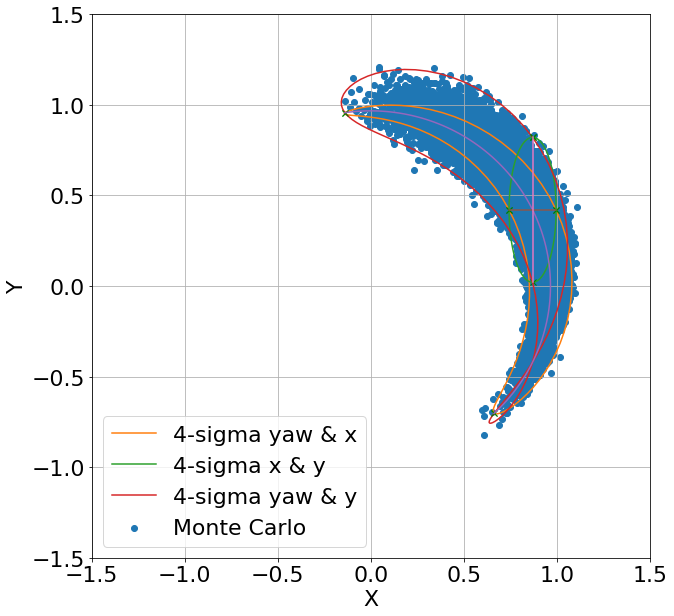

In [14]:
plt.figure(figsize=(10,10))
sigma = np.diag([0,0,0.1,0.001,0.01,0])

sigma_visualize(mrob.geometry.SE3([0,0,0.9,1,0,0]), sigma=sigma,N = 100, K=[4] )
plt.scatter(poses[:,0],poses[:,1], label='Monte Carlo')

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.legend()
plt.show()

The above plotted graphs show that Monte Carlo and ellipsoid "wire-frame" projections correspond to each other.

Another way to visualize the covariance ellipsoid would be to define a mesh grid on it's surface and use them for projection. It is a subject for future tests. 

## Pose compounding

Suppose there are two sequential pose increments:
    
$$
 \{T_1, \Sigma_1\}, \{T_2, \Sigma_2\}
$$

The pose compound procedure allow to obtain the resulting pose and covariance:

$$
    COMPOUND(\{T_1, \Sigma_1\}, \{T_2, \Sigma_2\}) \to \{T,\Sigma\}
$$

### Second order compounding

In [19]:
def compound_2nd(T1, sigma1, T2, sigma2):
    T = T_1.mul(T_2)
    T_1_adj = T_1.adj()
    sigma_2_ = T_1_adj@sigma_2@T_1_adj.transpose()
    sigma = sigma_1 + sigma_2_
    return T, sigma

In [16]:
T_1 = mrob.geometry.SE3([0,0,0,1,0,0])
sigma_1 = np.diag([0,0,0.03**2,0,0,0])

In [17]:
T_2 = mrob.geometry.SE3([0,0,0,0,1,0])
sigma_2 = np.diag([0,0,0.03**2,0,0,0])

<AxesSubplot:>

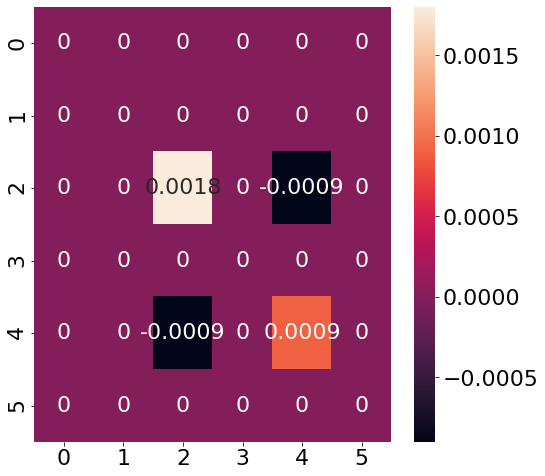

In [18]:
T, sigma = compound_2nd(T_1, sigma_2,T_2, sigma_2)
plt.figure(figsize=(8,8))
sns.heatmap(sigma,annot=True)

# Conclusions

# References

# TODO